# Stress Predcition Hackerton
## feature importance : SHAP, feature importance, gini index, permutation importance
## missing value : missforest

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [17]:
train = pd.read_csv('C:/Users/hananthony1/.vscode/lab_git/vscode/datafile/dacon/basic_stress_prediction/train.csv')
test = pd.read_csv('C:/Users/hananthony1/.vscode/lab_git/vscode/datafile/dacon/basic_stress_prediction/test.csv')
sample_submission = pd.read_csv('C:/Users/hananthony1/.vscode/lab_git/vscode/datafile/dacon/basic_stress_prediction/sample_submission.csv')

train.shape, test.shape, sample_submission.shape

((3000, 18), (3000, 17), (3000, 2))

<Axes: >

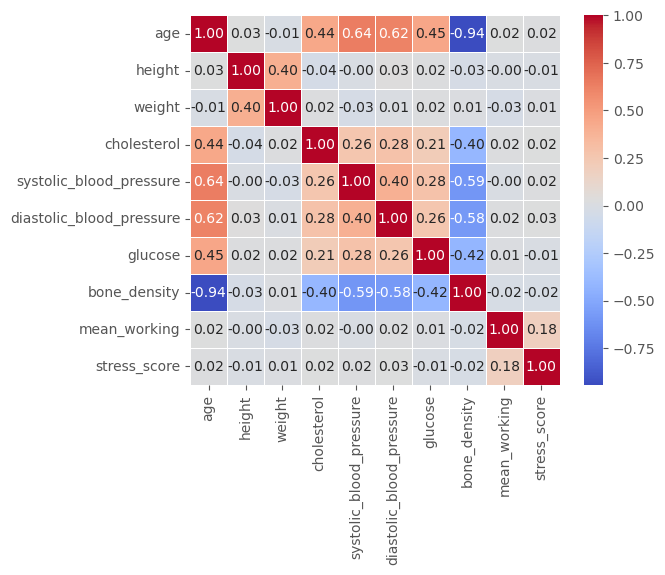

In [18]:
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

In [19]:
df_train = train.copy()
df_test = test.copy()

df_train.drop(columns=['ID','height','medical_history','family_medical_history'], inplace=True)
df_test.drop(columns=['ID','height','medical_history','family_medical_history'], inplace=True)

<Axes: >

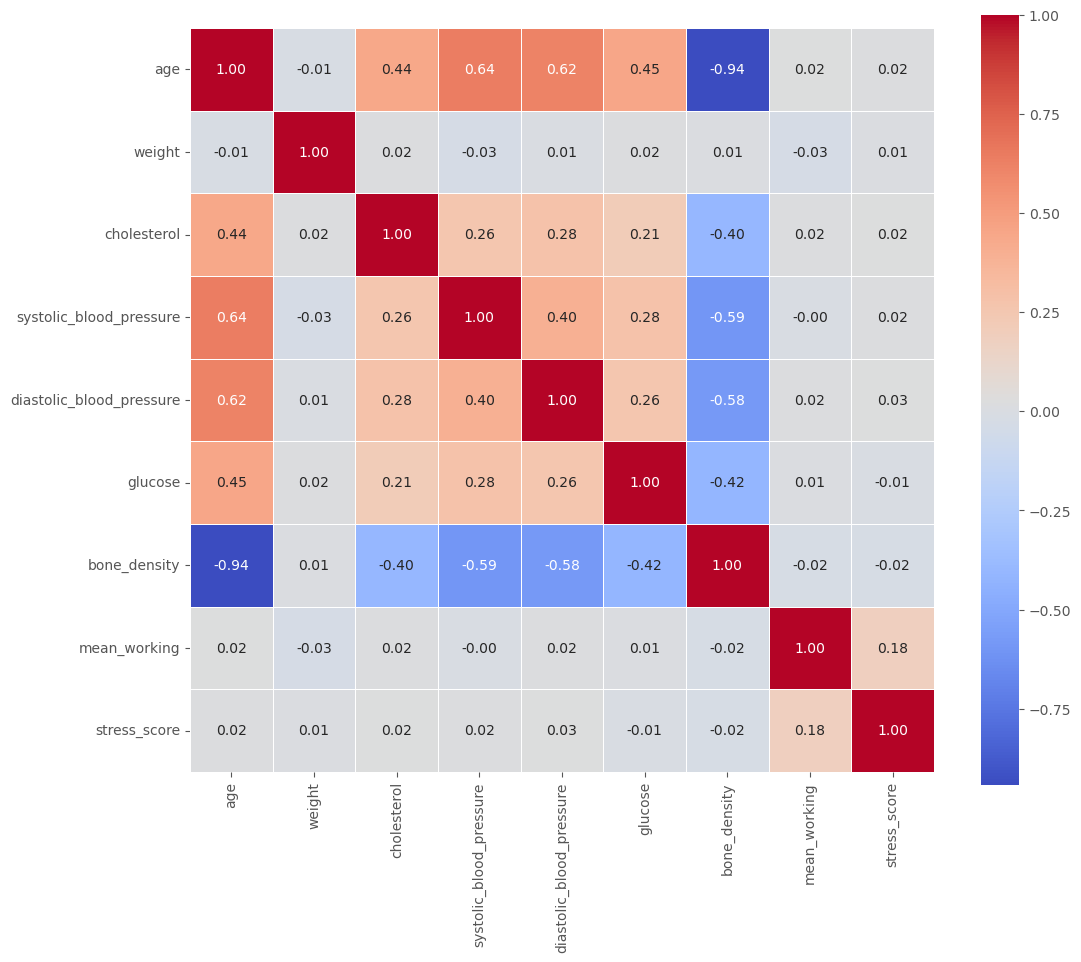

In [20]:
plt.figure(figsize=(12,10))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.7)

<Axes: xlabel='sleep_pattern', ylabel='stress_score'>

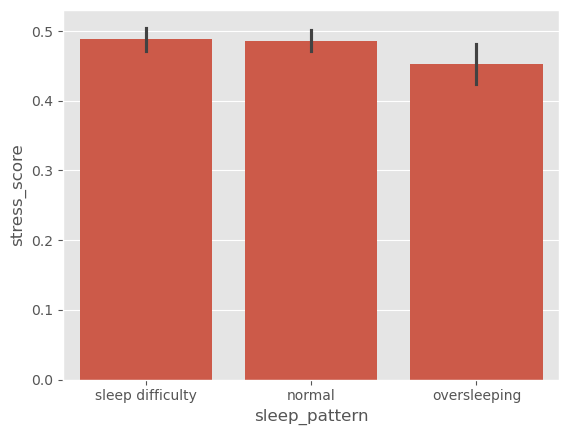

In [21]:
sns.barplot(data=train,x='sleep_pattern',y='stress_score')

In [22]:
# # High VIF features must be removed
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = pd.DataFrame()
# vif['VIF'] = [variance_inflation_factor(df_train.select_dtypes(include=['float64','int64']).values, i) for i in range(df_train.select_dtypes(include=['float64','int64']).shape[1])]
# vif['features'] = df_train.select_dtypes(include=['float64','int64']).columns
# vif.sort_values(by='VIF', ascending=False)

In [23]:
# #Create age_group column
# df_train['age_group'] = pd.cut(df_train['age'], bins=range(0,101,10), labels=[f'{i}s' for i in range(0,100,10)])
# df_test['age_group'] = pd.cut(df_test['age'], bins=range(0,101,10), labels=[f'{i}s' for i in range(0,100,10)])

# #Convert to category dtype
# df_train['age_group'] = df_train['age_group'].astype('category')
# df_test['age_group'] = df_test['age_group'].astype('category')

In [24]:
cat_col_tr = df_train.select_dtypes(include='object').columns
cat_col_te = df_test.select_dtypes(include='object').columns

In [25]:
df_train[cat_col_tr] = df_train[cat_col_tr].astype('category')
df_test[cat_col_te] = df_test[cat_col_te].astype('category')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_col_tr:
    df_train[col] = le.fit_transform(df_train[col])

# plt.figure(figsize=(12,8))
# sns.heatmap(df_train.corr(), cbar=False,annot=True,)  # No missing values in train set

In [26]:
# from missforest import MissForest
# from sklearn.model_selection import train_test_split

# mf = MissForest(categorical=cat_col_tr.tolist())
# mf.fit(x=df_train)
# df_train_imputed = mf.transform(df_train)

# mf = MissForest(categorical=cat_col_te.tolist())
# mf.fit(x=df_test)
# df_test_imputed = mf.transform(df_test)

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
numeric_col_tr = df_train.select_dtypes(include=['float64','int64']).columns
numeric_col_te = df_test.select_dtypes(include=['float64','int64']).columns

imp = IterativeImputer(max_iter=10, random_state=42)
mean_value_imputed_train = imp.fit_transform(df_train[numeric_col_tr])
df_train[numeric_col_tr] = mean_value_imputed_train

mean_value_imputed_test = imp.fit_transform(df_test[numeric_col_te])
df_test[numeric_col_te] = mean_value_imputed_test

In [13]:
#missing values filling
for col in []:
    df_train[col] = df_train[col].fillna(df_train[col].mean())
    df_test[col] = df_train[col].fillna(df_test[col].mean())

for col in []:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
    df_test[col] = df_train[col].fillna(df_test[col].mode()[0])

df_train = pd.get_dummies(df_train, columns=cat_col_tr, drop_first=True)
df_test = pd.get_dummies(df_test, columns=cat_col_te, drop_first=True)

# Models + Submission

## LightGBM
### baseline



In [230]:
# 3-Fold CV with LGBM
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

X = df_train.drop(columns=['stress_score'])
y= df_train['stress_score']

folds = KFold(n_splits=3, shuffle=True, random_state=42)
val_scores = []
results = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    print(f'Data Shape:{X_train.shape,y_train.shape,X_val.shape,y_val.shape}\n')

    lgb = LGBMRegressor(random_state=42,enable_categorical=True)
    lgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)])
    
    lgb_train_pred = lgb.predict(X_train)
    lgb_val_pred = lgb.predict(X_val)

    print(f'Train MAE: {mean_absolute_error(y_train,lgb_train_pred):.5f}')
    print(f'Val MAE: {mean_absolute_error(y_val,lgb_val_pred):.5f}')
    print('-'*30)

    val_scores.append(mean_absolute_error(y_val,lgb_val_pred))
    results.append(lgb.evals_result_)

print(f'MAE: {np.array(val_scores).mean()}')

Fold 1 / Fold 3
Data Shape:((2000, 18), (2000,), (1000, 18), (1000,))

Train MAE: 0.07924
Val MAE: 0.15934
------------------------------
Fold 2 / Fold 3
Data Shape:((2000, 18), (2000,), (1000, 18), (1000,))

Train MAE: 0.07871
Val MAE: 0.16923
------------------------------
Fold 3 / Fold 3
Data Shape:((2000, 18), (2000,), (1000, 18), (1000,))

Train MAE: 0.07655
Val MAE: 0.16496
------------------------------
MAE: 0.16450895614618527


### submission


## RandomForest
### baseline

In [231]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

X = df_train.drop(columns=['stress_score'])
y= df_train['stress_score']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae:.4f}')

Mean Absolute Error: 0.1529


### submission

In [ ]:
pipe.fit(X, y)
y_test = pipe.predict(df_test)

In [ ]:
sample_submission['stress_score'] = y_test
sample_submission.to_csv('rf_drop_3features.csv', index=False)

## XGBoost
### Baseline

In [232]:
# 3-Fold CV with XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

X = df_train.drop(columns=['stress_score'])
y= df_train['stress_score']

folds = KFold(n_splits=3, shuffle=True, random_state=42)
val_scores = []
results = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    print(f'Data Shape:{X_train.shape,y_train.shape,X_val.shape,y_val.shape}\n')

    xgb = XGBRegressor(random_state=42,enable_categorical=True)
    xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],verbose=False)
    
    xgb_train_pred = xgb.predict(X_train)
    xgb_val_pred = xgb.predict(X_val)

    print(f'Train MAE: {mean_absolute_error(y_train,xgb_train_pred):.5f}')
    print(f'Val MAE: {mean_absolute_error(y_val,xgb_val_pred):.5f}')
    print('-'*30)

    val_scores.append(mean_absolute_error(y_val,xgb_val_pred))
    results.append(xgb.evals_result())

print(f'MAE: {np.array(val_scores).mean()}')

Fold 1 / Fold 3
Data Shape:((2000, 18), (2000,), (1000, 18), (1000,))

Train MAE: 0.02232
Val MAE: 0.15196
------------------------------
Fold 2 / Fold 3
Data Shape:((2000, 18), (2000,), (1000, 18), (1000,))

Train MAE: 0.02363
Val MAE: 0.16122
------------------------------
Fold 3 / Fold 3
Data Shape:((2000, 18), (2000,), (1000, 18), (1000,))

Train MAE: 0.01858
Val MAE: 0.15988
------------------------------
MAE: 0.1576864395863656


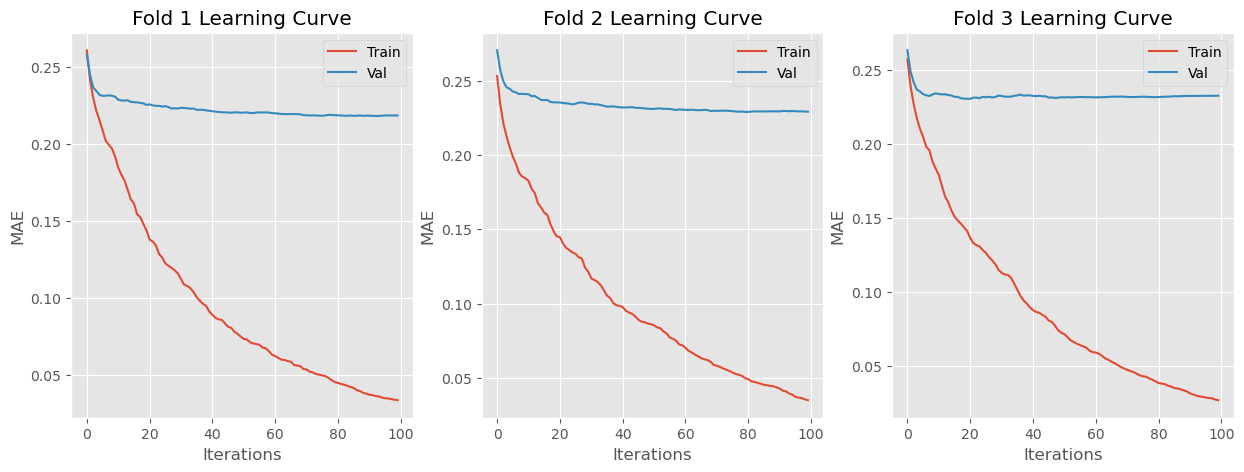

In [233]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for idx,result in enumerate(results):
    ax[idx].plot(result['validation_0']['rmse'], label='Train')
    ax[idx].plot(result['validation_1']['rmse'], label='Val')
    ax[idx].set_xlabel('Iterations')
    ax[idx].set_ylabel('MAE')
    ax[idx].legend()
    ax[idx].set_title(f'Fold {idx+1} Learning Curve')

c:\Users\hananthony1\AppData\Local\miniconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


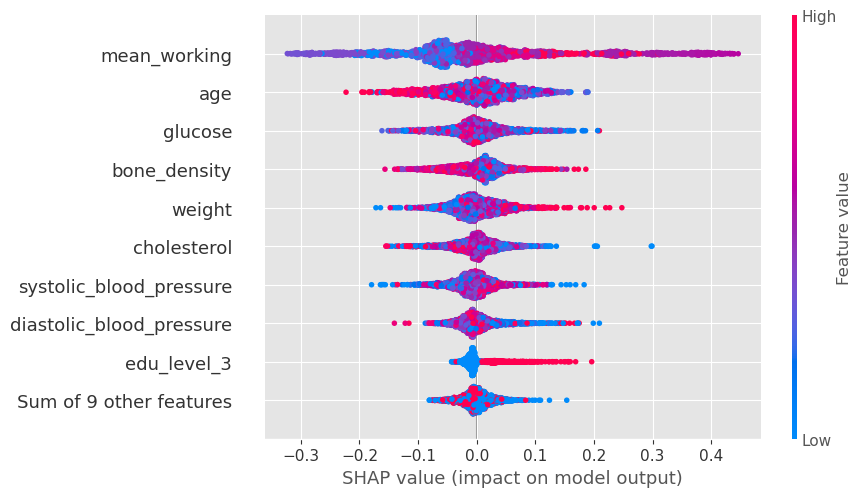

In [234]:
import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

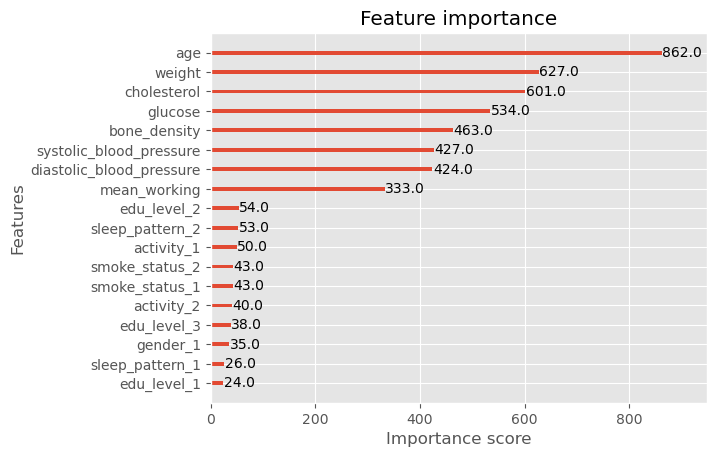

In [235]:
from xgboost import plot_importance
plot_importance(xgb)

In [236]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#XGBoost Baseline
X = df_train.drop(columns=['stress_score'])
y = df_train['stress_score']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

model = XGBRegressor(random_state=42,enable_categorical=True)
model.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val, y_val)],verbose=False)
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
print(f'XGBoost Baseline MAE: {mae:.4f}')

XGBoost Baseline MAE: 0.1443


### Submission

In [28]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42,enable_categorical=True)
X = df_train.drop(columns=['stress_score'])
y = df_train['stress_score']

xgb.fit(X,y)
y_test = xgb.predict(df_test)

In [29]:
sample_submission['stress_score'] = y_test
sample_submission.to_csv('xgboost_InteracitveImputer.csv', index=False)